In [2]:
import os
import pandas as pd
import regex as re
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [4]:
path_o = str(os.getcwd()).split("\\")
path_o = "\\".join(path_o[:-1])

In [5]:
os.chdir(path_o+"\\data\\processed")
df = pd.read_csv("data_processed.csv", index_col=0)
df.head()

,budget,genres,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,crew,cast,keywords,month,day,market_share_genres,people_vaccinated,people_fully_vaccinated,total_boosters,New_cases,New_deaths
0,7.405126e+07,0,11.773,1724,70,7.441348e+08,137.0,36,790,313,147,5,29,0.141761,0.0,0.0,0.0,0.0,0.0
1,2.962050e+07,1,13.786,1071,70,3.850665e+07,144.0,19,280,434,504,1,1,0.080776,0.0,0.0,0.0,0.0,0.0
2,2.221538e+07,1,25.768,45,70,1.406953e+08,95.0,19,2304,887,796,4,23,0.080776,0.0,0.0,0.0,0.0,0.0
3,7.405126e+07,1,7.547,1837,69,1.110769e+07,125.0,27,247,1843,681,10,29,0.080776,0.0,0.0,0.0,0.0,0.0
4,1.110769e+08,1,8.597,406,70,2.337024e+08,139.0,19,174,591,104,12,14,0.080776,0.0,0.0,0.0,0.0,0.0


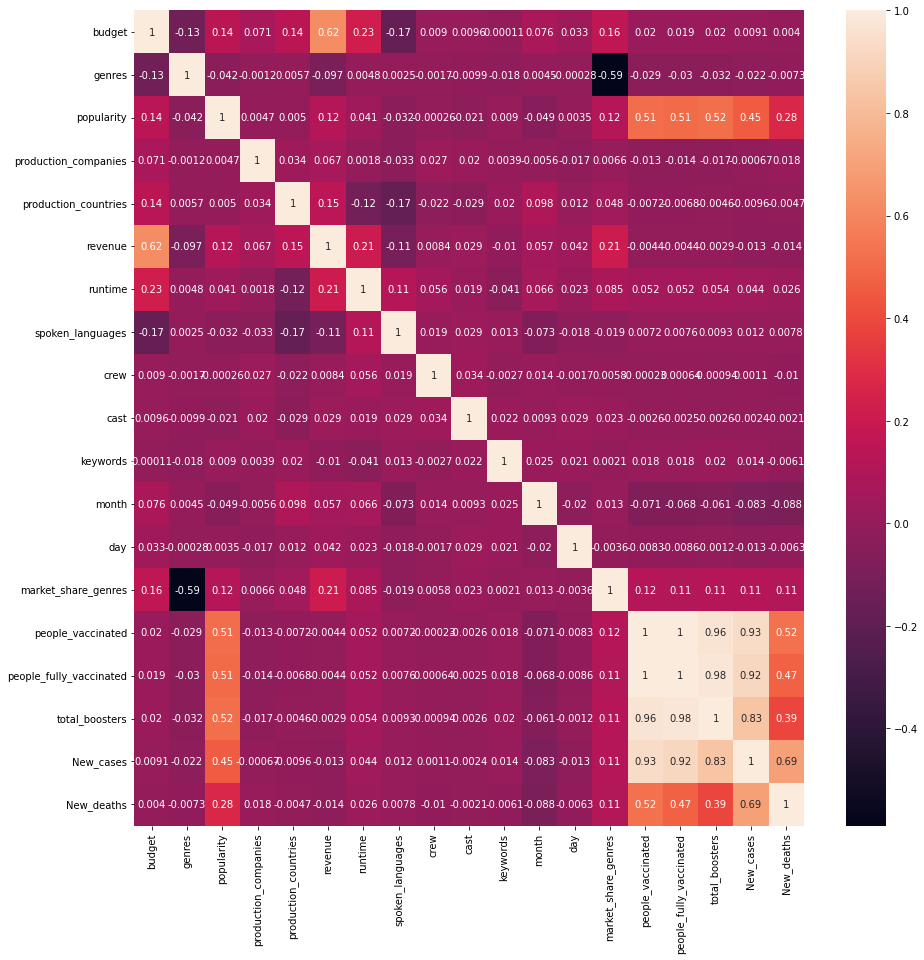

In [5]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True);

In [6]:
cols = ['budget', 'popularity', 'revenue', 'market_share_genres', 'runtime']
for i in cols:
    df[i] = np.log(df[i])

In [7]:
X = df.drop(columns=["revenue"])
y = df["revenue"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)


X_train (3738, 18)
X_test (1602, 18)
y_train (3738,)
y_test (1602,)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [11]:
regr = make_pipeline(SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)

Pipeline(steps=[('svr', SVR(epsilon=0.2))])

In [12]:
regr.score(X_test, y_test)

0.524570962528359

In [15]:
pipe = Pipeline(steps=[
    ('classifier', LinearRegression())
])

svr_params = {
    'classifier': [SVR()],
    'classifier__C': np.arange(0,1,0.1),
    'classifier__epsilon': np.arange(0,1,0.1),
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__degree': np.arange(0,10,1),
    
}
rnd_clf = {
            'classifier': [RandomForestRegressor(n_jobs=-1)],
            'classifier__n_estimators': np.arange(0,1000,10),
            'classifier__max_depth': np.arange(0, 20, 1),
            'classifier__max_leaf_nodes': np.arange(0,100,1),
            'classifier__min_samples_leaf':np.arange(0,100,1),
            'classifier__random_state':np.arange(0,100,1),

}
# Lasso_params = {
#     'classifier': [Lasso()],
#     'classifier__alpha': np.logspace(-10,10,50)
# }

# Elastic_params = {
#     'classifier': [ElasticNet()],
#     'classifier__alpha': np.logspace(-10,10,50),
#     'classifier__l1_ratio': np.arange(0,1,0.01)
# }

search_space = [
    rnd_clf
    # Lasso_params,
    # Elastic_params
]
kfold = KFold(n_splits=10)
clf = RandomizedSearchCV(estimator = pipe,
                  param_distributions = search_space,
                  n_jobs = 1,
                  verbose=10,
                  n_iter=100,
                  scoring="neg_mean_absolute_error",
                  cv = kfold)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START classifier=RandomForestRegressor(n_jobs=-1), classifier__max_depth=5, classifier__max_leaf_nodes=97, classifier__min_samples_leaf=63, classifier__n_estimators=60, classifier__random_state=3
[CV 1/10; 1/100] END classifier=RandomForestRegressor(n_jobs=-1), classifier__max_depth=5, classifier__max_leaf_nodes=97, classifier__min_samples_leaf=63, classifier__n_estimators=60, classifier__random_state=3;, score=-1.113 total time=   1.2s
[CV 2/10; 1/100] START classifier=RandomForestRegressor(n_jobs=-1), classifier__max_depth=5, classifier__max_leaf_nodes=97, classifier__min_samples_leaf=63, classifier__n_estimators=60, classifier__random_state=3
[CV 2/10; 1/100] END classifier=RandomForestRegressor(n_jobs=-1), classifier__max_depth=5, classifier__max_leaf_nodes=97, classifier__min_samples_leaf=63, classifier__n_estimators=60, classifier__random_state=3;, score=-1.039 total time=   0.1s
[CV 3/10; 1/100] ST

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('classifier',
                                              LinearRegression())]),
                   n_iter=100, n_jobs=1,
                   param_distributions=[{'classifier': [RandomForestRegressor(max_depth=19,
                                                                              max_leaf_nodes=69,
                                                                              min_samples_leaf=14,
                                                                              n_estimators=220,
                                                                              n_jobs=-1,
                                                                              random_state=71)],
                                         'classifier__max_depth': array([ 0,  1,  2,  3,  4,...
                                         'classifier__random_state': array([ 0,  1,  2, 

In [16]:
clf.best_params_

{'classifier__random_state': 71,
 'classifier__n_estimators': 220,
 'classifier__min_samples_leaf': 14,
 'classifier__max_leaf_nodes': 69,
 'classifier__max_depth': 19,
 'classifier': RandomForestRegressor(max_depth=19, max_leaf_nodes=69, min_samples_leaf=14,
                       n_estimators=220, n_jobs=-1, random_state=71)}

In [17]:
clf.best_estimator_.score(X_test, y_test)

0.5069365419183713

In [19]:
clf.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestRegressor(max_depth=19, max_leaf_nodes=69,
                                       min_samples_leaf=14, n_estimators=220,
                                       n_jobs=-1, random_state=71))])

In [18]:
predictions = clf.best_estimator_.predict(X_test)

print('MAE:', mean_absolute_error(np.exp(y_test), np.exp(predictions)))
print('MAPE:', mean_absolute_percentage_error(np.exp(y_test), np.exp(predictions)))
print('MSE:', mean_squared_error(np.exp(y_test), np.exp(predictions)))
print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions))))

MAE: 76259888.36655986
MAPE: 75.12249111323256
MSE: 3.6028738383060924e+16
RMSE: 189812376.79103258


In [20]:
os.chdir(path_o+"\\model")
with open('model_V7', 'wb') as archivo_salida:
    pickle.dump(clf, archivo_salida)

In [270]:
clf.best_estimator_

DecisionTreeRegressor(max_depth=6, min_samples_leaf=34, min_samples_split=51,
                      random_state=33)

In [26]:
new_register = {"id": 7,
                "Name_pickle": "model_V7",
                "Model":clf.best_estimator_[0], 
                "Description":"Random Forest Regression, RandomSearch, log y scalar",
                 "Score":clf.best_estimator_.score(X_test, y_test),
                 "MAE":mean_absolute_error(np.exp(y_test), np.exp(predictions)),
                 "MAPE":mean_absolute_percentage_error(np.exp(y_test), np.exp(predictions)),
                 "MSE":mean_squared_error(np.exp(y_test), np.exp(predictions)),
                 "RMSE":np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions)))}

df_models_results = pd.read_csv("models.csv", index_col=0)
df_models_results = df_models_results.append(new_register, ignore_index=True)
df_models_results

,id,Name_pickle,Model,Description,Score,MAE,MAPE,MSE,RMSE
0,1,model_V1,LinearRegression(n_jobs=-1),"Regresion Lineal, todas variables, scalar",0.317380,1.066576e+08,2301.643886,4.358168e+16,2.087623e+08
1,2,model_V2,LinearRegression(n_jobs=-1),"Regresion Lineal, no variables label, scalar",0.321573,1.045033e+08,1015.764484,4.331397e+16,2.081201e+08
2,3,model_V3,LinearRegression(n_jobs=-1),"Regresion Lineal, no variables label, log y sc...",0.540263,9.017102e+07,126.927164,8.128038e+16,2.850971e+08
3,4,model_V4,"ElasticNet(alpha=0.03727593720314938, l1_ratio...","Regresion Lineal, Regularizacion (Lasso, Ridge...",0.546992,8.217304e+07,126.894813,5.307954e+16,2.303900e+08
4,5,model_V5,LinearRegression(n_jobs=-1),"Regresion polinomial degree 2, solo variables ...",0.500419,1.013636e+08,99.799883,4.086116e+17,6.392274e+08
5,6,model_V6,"DecisionTreeRegressor(max_depth=6, min_samples...","Decision Arbol Regresion, RandomSearch, log y ...",0.471791,7.878713e+07,92.183933,3.638590e+16,1.907509e+08
6,7,model_V7,"(DecisionTreeRegressor(max_depth=19, max_featu...","Random Forest Regression, RandomSearch, log y ...",0.506937,7.625989e+07,75.122491,3.602874e+16,1.898124e+08


In [27]:
df_models_results.to_csv("models.csv")